In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from src.forecasting import (
    TimeSeriesDataLoader,
    TimeSeriesDataset,
    LSTMForecaster,
    create_sequences,
    train_model,
    plot_losses
)

# Set random seed for reproducibility
torch.manual_seed(42)

Epoch [10/300], Train Loss: 0.0252, Val Loss: 0.0330
Epoch [20/300], Train Loss: 0.0236, Val Loss: 0.0310
Epoch [30/300], Train Loss: 0.0230, Val Loss: 0.0292
Epoch [40/300], Train Loss: 0.0231, Val Loss: 0.0308
Epoch [50/300], Train Loss: 0.0225, Val Loss: 0.0327
Epoch [60/300], Train Loss: 0.0215, Val Loss: 0.0347
Epoch [70/300], Train Loss: 0.0216, Val Loss: 0.0369
Epoch [80/300], Train Loss: 0.0211, Val Loss: 0.0360
Epoch [90/300], Train Loss: 0.0198, Val Loss: 0.0353
Epoch [100/300], Train Loss: 0.0175, Val Loss: 0.0335
Epoch [110/300], Train Loss: 0.0154, Val Loss: 0.0392
Epoch [120/300], Train Loss: 0.0133, Val Loss: 0.0407
Epoch [130/300], Train Loss: 0.0115, Val Loss: 0.0463
Epoch [140/300], Train Loss: 0.0102, Val Loss: 0.0482
Epoch [150/300], Train Loss: 0.0092, Val Loss: 0.0535
Epoch [160/300], Train Loss: 0.0084, Val Loss: 0.0573
Epoch [170/300], Train Loss: 0.0077, Val Loss: 0.0501
Epoch [180/300], Train Loss: 0.0071, Val Loss: 0.0524
Epoch [190/300], Train Loss: 0.0068, 

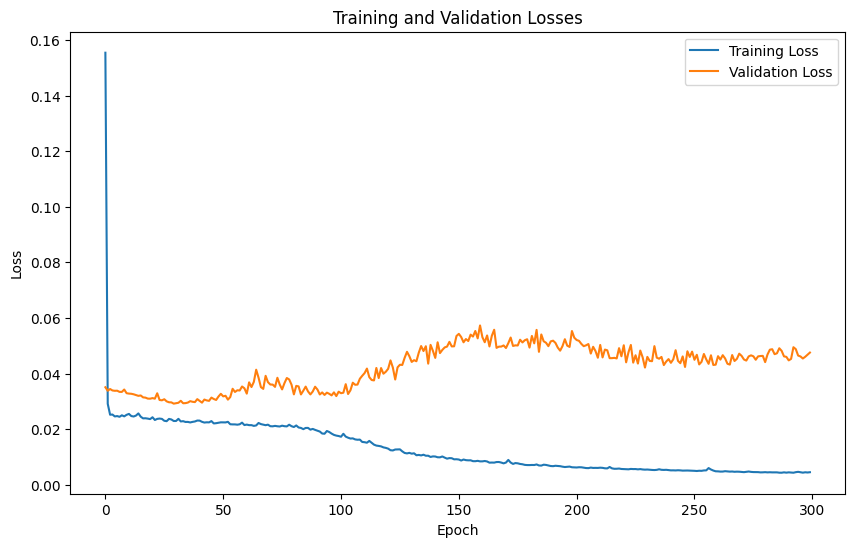

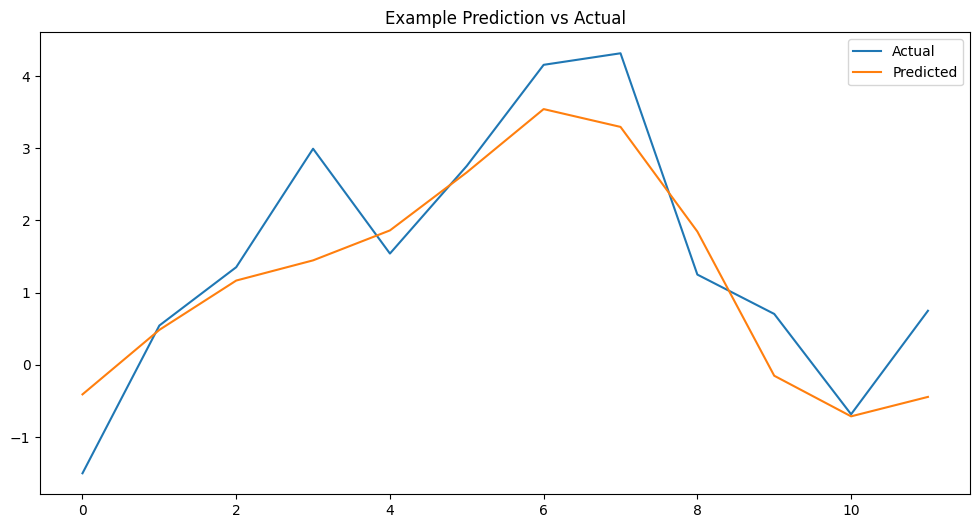

In [68]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize data loader
data_loader = TimeSeriesDataLoader(
    file_path="../../data/synthetic/causal_4cols_1000rows.csv",
    target_column="$Y$"
)

# Load and preprocess data
X, y = data_loader.load_data()

# Create sequences
X_train, y_train, X_test, y_test = create_sequences(
    X=X,
    y=y,
    back_horizon=24,
    forecast_horizon=12,
    train_size=0.8
)

# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

# Initialize model
model = LSTMForecaster(
    input_size=X.shape[1],  # Number of features
    hidden_size=64,
    num_layers=2,
    output_size=12,  # forecast_horizon
    dropout=0.2
)

# Train model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    epochs=300,
    learning_rate=0.001,
    device=device
)

# Plot losses
plot_losses(train_losses, val_losses)

# Make predictions
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        predictions.extend(pred.cpu().numpy())
        actuals.extend(y_batch.numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Inverse transform predictions and actuals if needed
predictions = data_loader.target_scaler.inverse_transform(predictions)
actuals = data_loader.target_scaler.inverse_transform(actuals)


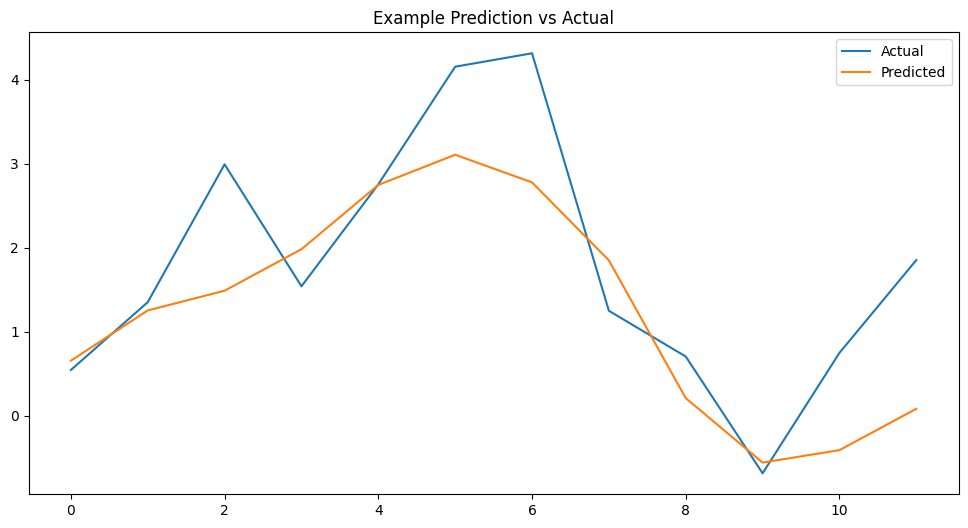

In [71]:

# Plot some example predictions and the 
plt.figure(figsize=(12, 6))
plt.plot(actuals[1], label='Actual')
plt.plot(predictions[1], label='Predicted')
plt.title('Example Prediction vs Actual')
plt.legend()
plt.show()
